### 1. Business/Real-world Problem

#### 1.1. What is Malware?

The term malware is a contraction of malicious software. Put simply, malware is any piece of software that was written with the intent of doing harm to data, devices or to people.

Source: https://www.avg.com/en/signal/what-is-malware

#### 1.2. Problem Statement

In the past few years, the malware industry has grown very rapidly that, the syndicates invest heavily in technologies to evade traditional protection, forcing the anti-malware groups/communities to build more robust softwares to detect and terminate these attacks. The major part of protecting a computer system from a malware attack is to **identify whether a given piece of file/software is a malware**.

#### 1.3 Source/Useful Links

Microsoft has been very active in building anti-malware products over the years and it runs it’s anti-malware utilities over 150 million computers around the world. This generates tens of millions of daily data points to be analyzed as potential malware. In order to be effective in analyzing and classifying such large amounts of data, we need to be able to group them into groups and identify their respective families.

This dataset provided by Microsoft contains about 9 classes of malware.

Source: https://www.kaggle.com/c/malware-classification

#### 1.4. Real-world/Business Objectives and Constraints

1. Minimize multi-class error.
2. Multi-class probability estimates.
3. Malware detection should not take hours and block the user's computer. It should fininsh in a few seconds or a minute.

### 2. Machine Learning Problem

#### 2.1. Data

##### 2.1.1. Data Overview

* Source : https://www.kaggle.com/c/malware-classification/data
* For every malware, we have two files
    * .asm file (read more: https://www.reviversoft.com/file-extensions/asm)
    * .bytes file (the raw data contains the hexadecimal representation of the file's binary content, without the PE header)
* Total train dataset consist of 200GB data out of which 50GB of data is .bytes files and 150GB of data is .asm files.
* Lots of Data for a single-box/computer.
* There are total 10, 868 .bytes files and 10,868 asm files total 21, 736 files
* There are 9 types of malwares (9 classes) in our give data.
* Types of Malware:
    1. Ramnit
    2. Lollipop
    3. Kelihos_ver3
    4. Vundo
    5. Simda
    6. Tracur
    7. Kelihos_ver1
    8. Obfuscator.ACY
    9. Gatak

#### 2.2. Mapping the Real-world Problem to an ML Problem

##### 2.2.1. Type of Machine Learning Problem

There are nine different classes of malware that we need to classify a given a data point - Multi class classification problem.

##### 2.2.2. Performance Metric

Source: https://www.kaggle.com/c/malware-classification#evaluation

Metric(s):
* Multi class log-loss
* Confusion matrix

##### 2.2.3. Machine Learing Objectives and Constraints

Objective: Predict the probability of each data-point belonging to each of the nine classes.

Constraints:
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* Some Latency constraints.

#### 2.3. Train and Test Dataset

Split the dataset randomly into three parts train, cross validation and test with 64%, 16%, 20% of data respectively.

#### 2.4. Useful Blogs, Videos and Papers

* http://blog.kaggle.com/2015/05/26/microsoft-malware-winners-interview-1st-place-no-to-overfitting/
* https://arxiv.org/pdf/1511.04317.pdf
* First place solution in Kaggle competition: https://www.youtube.com/watch?v=VLQTRlLGz5Y
* https://github.com/dchad/malware-detection
* http://vizsec.org/files/2011/Nataraj.pdf
* Cross validation is more trustworthy than domain knowledge: https://www.dropbox.com/sh/gfqzv0ckgs4l1bf/AAB6EelnEjvvuQg2nu_pIB6ua?dl=0

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import codecs
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shutil
import random as r

In [3]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-deep')

In [4]:
from multiprocessing import Process

In [5]:
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
from xgboost import XGBClassifier

In [8]:
from IPython.display import display

### 3. Exploratory Data Analysis

In [11]:
label_df = pd.read_csv(filepath_or_buffer='data/trainLabels.csv')

In [19]:
display(label_df.columns)
display(label_df.head())
display(label_df.describe())

Index(['Id', 'Class'], dtype='object')

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


,Class
count,10868.000000
mean,4.017851
std,2.684621
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,9.000000


In [16]:
def class_distribution(data, label, title='Data'):
    """
    This function plots the distribution of given data[label].
    """
    class_val_counts = data[label].value_counts().to_frame()
    percents = class_val_counts.apply(lambda x: round((x / data.shape[0]) * 100, 2))
    class_val_counts['Percentage'] = percents
    display(class_val_counts)
    
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=class_val_counts.index, y=class_val_counts[label])
    for bar in bars.patches:
        bars.annotate(text=format(bar.get_height()),
                      xy=((bar.get_x() + bar.get_width() / 2), bar.get_height()),
                      ha='center',
                      va='center',
                      size=10,
                      xytext=(0, 6),
                      textcoords='offset points')
    plt.xlabel(xlabel=label)
    plt.ylabel(ylabel='Value Counts')
    plt.title(label=title)
    plt.grid()
    plt.show()

,Class,Percentage
3,2942,27.07
2,2478,22.80
1,1541,14.18
8,1228,11.30
9,1013,9.32
6,751,6.91
4,475,4.37
7,398,3.66
5,42,0.39


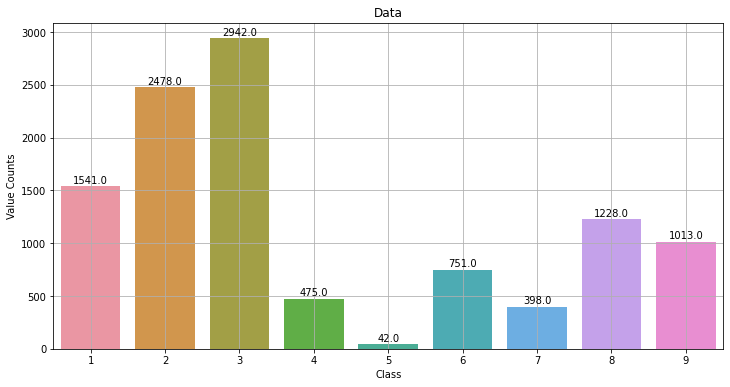

In [17]:
class_distribution(data=label_df, label='Class')

Feature Extraction

In [38]:
def get_file_sizes(label_df, is_bytes=True):
    """
    This function gets the file size.
    """
    size_type = 1024.0 * 1024 # converts to MB.
    if is_bytes:
        dir_path = os.path.join('data/train', 'train_bytes_files')
    else:
        dir_path = os.path.join('data/train', 'train_asm_files')
    all_files = os.listdir(path=dir_path)
    all_sizes = [os.stat(path=os.path.join(dir_path, filepath)).st_size / size_type
                 for filepath in all_files]
    file_names = [f_name.split('.')[0] for f_name in all_files]
    file_size_df = pd.DataFrame(data={'Id': file_names, 'Size': all_sizes})
    file_size_class_df = label_df.merge(right=file_size_df)
    return file_size_class_df

In [39]:
file_size_class_df = get_file_sizes(label_df=label_df)

In [41]:
display(file_size_class_df.head())
display(file_size_class_df.describe())

,Id,Class,Size
0,01kcPWA9K2BOxQeS5Rju,1,0.679688
1,04EjIdbPV5e1XroFOpiN,1,0.849609
2,05EeG39MTRrI6VY21DPd,1,0.509766
3,05rJTUWYAKNegBk2wE8X,1,2.789551
4,0AnoOZDNbPXIr2MRBSCJ,1,0.566406


,Class,Size
count,10868.000000,10868.000000
mean,4.017851,4.461899
std,2.684621,3.566332
min,1.000000,0.107410
25%,2.000000,0.835449
50%,3.000000,4.168626
75%,6.000000,8.099609
max,9.000000,53.298828


Boxplot of file-sizes

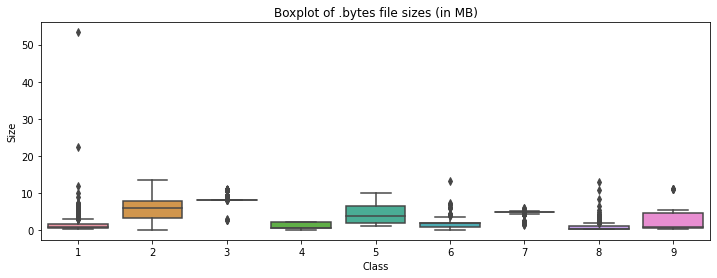

In [52]:
plt.figure(figsize=(12, 4))
sns.boxplot(x='Class', y='Size', data=file_size_class_df)
plt.title("Boxplot of .bytes file sizes (in MB)")
plt.show()